# Non-covalent interactions benchmark

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Non-covalent interactions benchmark'
parallel = None  # how many jobs to run at once

In [3]:
methods = {"HF": "df-hf", "MP2": "df-mp2", "LMP2": "df-lmp2", }
bases = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ']

In [4]:
db = pymolpro.database.load("GMTKN55_S22").subset('small')

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, method=methods[method], basis=basis, location=project_name,
                                                       backend=backend, parallel=parallel)

In [6]:
for method in methods:
    for result in pymolpro.database.basis_extrapolate(results[method].values(),results['HF'].values()):
        results[method][result.basis]=result
    for basis in results[method]:
        if basis not in bases: bases.append(basis)

In [7]:
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db, 'kJ/mol')[
                    'reaction statistics']
with open(project_name + '.method_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(method_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Method errors'))
method_errors

,DF-HF/aug-cc-pVQZ,DF-MP2/aug-cc-pVQZ,DF-LMP2/aug-cc-pVQZ
MAD,6.08,0.22,0.54
MAXD,7.52,0.42,0.79
RMSD,6.30,0.28,0.58
MSD,-6.08,0.22,-0.54
STDEVD,2.03,0.21,0.26


In [8]:
for key, table in pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db).items():
    print(key)
    print(table)

results
[{'method': ['hf', 'df-hf'], 'basis': 'aug-cc-pVQZ', 'unit': 'Hartree', 'molecule energies': {'02': -152.137348921515, '08': -80.4318272687273, '01': -112.450005978623, '01a': -56.2239391353761, '02a': -76.0660246769283, '08a': -40.2162104675589}}, {'method': ['hf', 'df-mp2'], 'basis': 'aug-cc-pVQZ', 'unit': 'Hartree', 'molecule energies': {'02': -152.711896534593, '08': -80.8555325153533, '01': -112.960568865909, '01a': -56.4777418852842, '02a': -76.3518936483437, '08a': -40.4273483053424}}, {'method': ['hf', 'df-lmp2'], 'basis': 'aug-cc-pVQZ', 'unit': 'Hartree', 'molecule energies': {'02': -152.709533151809, '08': -80.8536174728202, '01': -112.958067503889, '01a': -56.4766434227825, '02a': -76.3509422922261, '08a': -40.4264399856976}}]
reaction energies
   DF-HF/aug-cc-pVQZ  DF-MP2/aug-cc-pVQZ  DF-LMP2/aug-cc-pVQZ
2           5.30e-03            8.11e-03             7.65e-03
1           2.13e-03            5.09e-03             4.78e-03
8          -5.94e-04            8.36e-04

In [9]:
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db, 'kJ/mol')[
                    'reaction energy deviations']
method_errors

,DF-HF/aug-cc-pVQZ,DF-MP2/aug-cc-pVQZ,DF-LMP2/aug-cc-pVQZ
2,-6.96,0.42,-0.79
1,-7.52,0.24,-0.56
8,-3.76,-0.01,-0.27


In [10]:
pd.set_option('display.precision', 2)
basis_errors = pymolpro.database.analyse([results['LMP2'][basis] for basis in bases], db, 'kJ/mol')[
    'reaction statistics']
with open(project_name + '.basis_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(basis_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Basis errors'))
basis_errors

,DF-LMP2/aug-cc-pVDZ,DF-LMP2/aug-cc-pVTZ,DF-LMP2/aug-cc-pVQZ,DF-LMP2/aug-cc-pV[23]Z,DF-LMP2/aug-cc-pV[34]Z
MAD,1.43,4.05,0.54,4.86,2.24
MAXD,2.23,10.63,0.79,13.76,6.46
RMSD,1.64,6.18,0.58,7.95,3.73
MSD,-1.21,-4.05,-0.54,-4.86,2.07
STDEVD,1.36,5.71,0.26,7.71,3.81


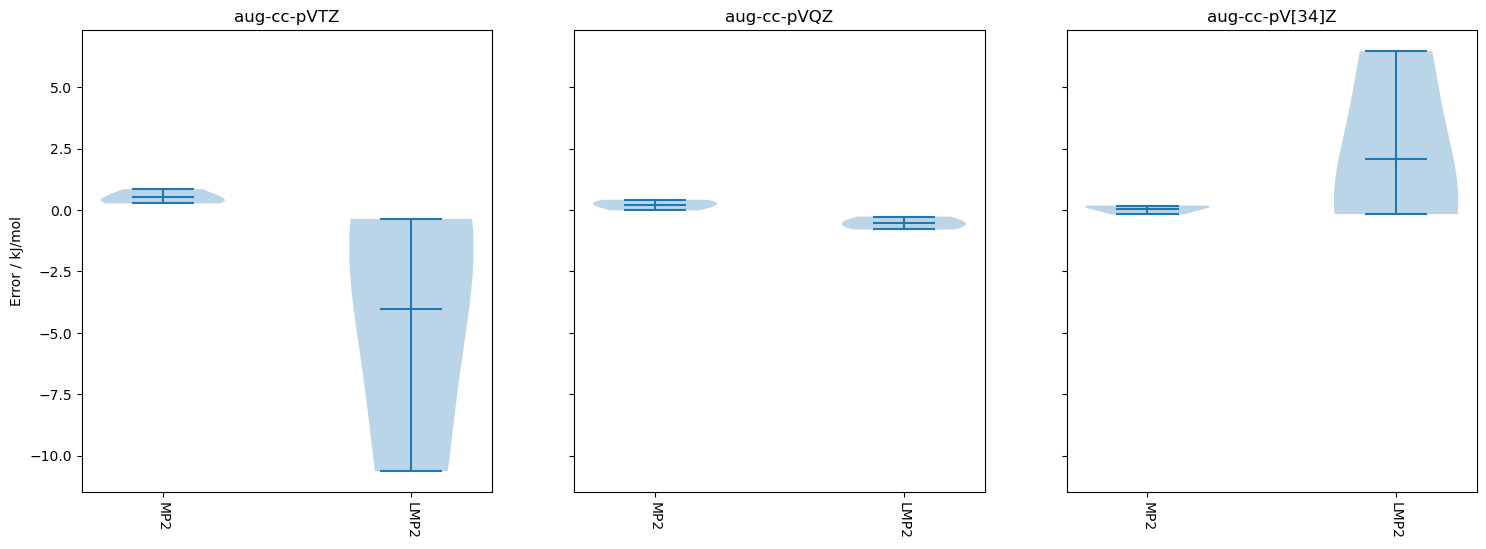

In [11]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV[34]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      db,'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")

In [12]:
basis_errors.to_latex(float_format='%.2f')

'\\begin{tabular}{lrrrrr}\n\\toprule\n & DF-LMP2/aug-cc-pVDZ & DF-LMP2/aug-cc-pVTZ & DF-LMP2/aug-cc-pVQZ & DF-LMP2/aug-cc-pV[23]Z & DF-LMP2/aug-cc-pV[34]Z \\\\\n\\midrule\nMAD & 1.43 & 4.05 & 0.54 & 4.86 & 2.24 \\\\\nMAXD & 2.23 & 10.63 & 0.79 & 13.76 & 6.46 \\\\\nRMSD & 1.64 & 6.18 & 0.58 & 7.95 & 3.73 \\\\\nMSD & -1.21 & -4.05 & -0.54 & -4.86 & 2.07 \\\\\nSTDEVD & 1.36 & 5.71 & 0.26 & 7.71 & 3.81 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [13]:
print(basis_errors.style.format(precision=3).to_latex(hrules=True,multicol_align='c'))

\begin{tabular}{lrrrrr}
\toprule
 & DF-LMP2/aug-cc-pVDZ & DF-LMP2/aug-cc-pVTZ & DF-LMP2/aug-cc-pVQZ & DF-LMP2/aug-cc-pV[23]Z & DF-LMP2/aug-cc-pV[34]Z \\
\midrule
MAD & 1.435 & 4.047 & 0.539 & 4.857 & 2.239 \\
MAXD & 2.228 & 10.627 & 0.793 & 13.761 & 6.464 \\
RMSD & 1.642 & 6.175 & 0.580 & 7.952 & 3.734 \\
MSD & -1.207 & -4.047 & -0.539 & -4.857 & 2.071 \\
STDEVD & 1.364 & 5.712 & 0.262 & 7.712 & 3.805 \\
\bottomrule
\end{tabular}

